In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from ms2pip.ms2pipC import MS2PIP
import os
import re
import pandas as pd
import numpy as np
from scipy.stats import rankdata, scoreatpercentile
from pyteomics import parser, fasta

In [2]:
CELL_LINES = ['82', 'P', 'KOR', 'KIS']
REPS = ['1', '2', '3']
BASE_DIR = '/home/lab006/Splicing_2021/Search_Results_RefSeq/fragpipe/'
MGF_DIR = '/home/lab006/Data/External/Melanoma/Chernobrovkin_012017/msconvert-mgf'

In [3]:
modmap = {'57.0215': 'Carbamidomethyl', '27.9949': 'Formyl'}
def transform_mods(s):
    mods = []
    if pd.isnull(s):
        return '-'
    for part in s.split(', '):
        aa, mass = re.match(r'((?:\d+[A-Z])|(?:[NC]-term))\((\d+\.\d+)\)', part).groups()
        if aa == 'N-term':
            loc = 0
        elif aa == 'C-term':
            loc = -1
        else:
            loc = int(aa[:-1])
        mods.append((loc, modmap[mass]))
    mods.sort()      
    return '|'.join(f'{location}|{name}' for location, name in mods)

params = {
     "ms2pip": {
         "ptm": [
             # "Oxidation,15.994915,opt,M",
             "Carbamidomethyl,57.021464,opt,C",
             "Formyl,27.9949,opt,N-term",
         ],
         "frag_method": "HCD",
         "frag_error": 0.01,
         "out": "csv",
         "sptm": [], "gptm": [],
     }
}

In [4]:
psms_all = {}
for cl in CELL_LINES:
    for rep in REPS:
        psms = pd.read_table(os.path.join(BASE_DIR, f'{cl}_{rep}', 'psm.tsv'))
        psms['modifications'] = psms['Assigned Modifications'].apply(transform_mods)
        psms['spec_id'] = psms['Spectrum'].str.replace(r'\.0+', r'.', regex=True)
    
        # print(psms['Peptide'].apply(lambda s: len(denormalize.get(s, [s])) > 1).sum())
        # psms['Peptide'] = psms['Peptide'].apply(lambda s: denormalize.get(s, [s])[0])
        
        psms_all[(cl, rep)] = psms

psms = pd.concat(psms_all.values())

In [6]:
for (cl, rep), psm in psms_all.items():
    ms2pip_input = psm[['spec_id', 'modifications', 'Peptide', 'Charge']].rename(columns={'Peptide': 'peptide', 'Charge': 'charge'})
    fbase = ms2pip_input.loc[0, 'spec_id'].rsplit('_', 2)[0]
    spec_file = os.path.join(MGF_DIR, f'{fbase}_{cl}_{rep}.mgf')
    ms2pip = MS2PIP(ms2pip_input, spec_file=spec_file,
                params=params, num_cpu=12, compute_correlations=True, output_filename=f'ms2pip_out_refseq_{cl}_{rep}')
    ms2pip.run()
    print(f'MS2PIP done for {cl} ({rep})')

(2)500 (4)500 (6)500 (11)500 (0)500 (1)500 (3)500 (8)500 (9)500 (7)500 (10)500 (5)500 (1)1000 (6)1000 (4)1000 (2)1000 (10)1000 (11)1000 (3)1000 (5)1000 (7)1000 (0)1000 (9)1000 (8)1000 (1)1500 (7)1500 (6)1500 (4)1500 (2)1500 (11)1500 (3)1500 (10)1500 (9)1500 (0)1500 (5)1500 (8)1500 (4)2000 (6)2000 (2)2000 (10)2000 (7)2000 (1)2000 (9)2000 (11)2000 (0)2000 (3)2000 (5)2000 (8)2000 
MS2PIP done for 82 (1)
(8)500 (6)500 (11)500 (9)500 (3)500 (10)500 (7)500 (0)500 (5)500 (2)500 (1)500 (4)500 (6)1000 (9)1000 (8)1000 (11)1000 (7)1000 (10)1000 (2)1000 (1)1000 (0)1000 (5)1000 (3)1000 (4)1000 (6)1500 (8)1500 (11)1500 (9)1500 (7)1500 (2)1500 (5)1500 (0)1500 (1)1500 (10)1500 (4)1500 (3)1500 (6)2000 (7)2000 (9)2000 (10)2000 (8)2000 (11)2000 (5)2000 (2)2000 (0)2000 (4)2000 (1)2000 (3)2000 
MS2PIP done for 82 (2)
(2)500 (8)500 (11)500 (10)500 (7)500 (5)500 (4)500 (3)500 (9)500 (1)500 (6)500 (0)500 (2)1000 (11)1000 (4)1000 (7)1000 (3)1000 (8)1000 (10)1000 (9)1000 (5)1000 (0)1000 (1)1000 (6)1000 (2)1500 

In [5]:
results = []
for cl in CELL_LINES:
    for rep in REPS:
        r = pd.read_csv(f'ms2pip_out_refseq_{cl}_{rep}_correlations.csv', index_col=0)
        r['percentile'] = rankdata(r.pearsonr) / r.shape[0]
        r['cell line'] = cl
        results.append(r)
result = pd.concat(results)

In [6]:
df = pd.merge(psms, result, on='spec_id')

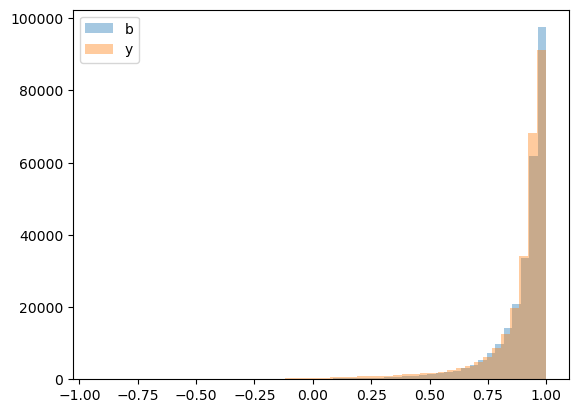

In [7]:
plt.hist(df.loc[df.ion == 'B', 'pearsonr'], bins=50, alpha=0.4, label='b')
plt.hist(df.loc[df.ion == 'Y', 'pearsonr'], bins=50, alpha=0.4, label='y')
plt.legend()
None

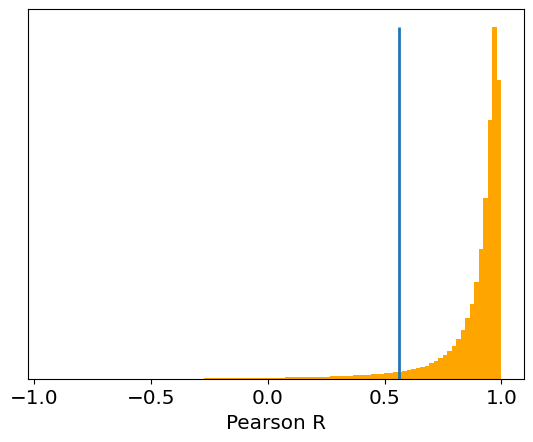

In [17]:
y, x, _ = plt.hist(df['pearsonr'], bins=100, color='orange')
plt.vlines(scoreatpercentile(df['pearsonr'], 5), 0, y.max(), lw=2)
plt.xlabel('Pearson R', fontsize='x-large')
plt.xticks(np.linspace(-1, 1, 5), fontsize='x-large')
plt.gca().get_yaxis().set_visible(False)

plt.savefig('pearsonr_hist.svg')

In [10]:
peptides = pd.read_table(os.path.join(BASE_DIR, 'combined_peptide.tsv'), index_col=0)
# peptides = peptides.loc[~peptides.index.duplicated()].copy()

In [15]:
swiss = set()
with fasta.read('/home/lab006/fasta/sprot_human_decoy.fasta') as f:
    for d, s in f:
        swiss |= parser.cleave(s, '[RK]', 2)

In [48]:
out = pd.merge(peptides.loc[~peptides.index.isin(swiss)], df, left_index=True, right_on='Peptide', how='left')
# out['Gene'] = out['ID original'].str.extract(r'[^:]*: ([^;]+)')

In [39]:
out[['Peptide', 'cell line', 'pearsonr', 'percentile']]

,Peptide,cell line,pearsonr,percentile
170650.0,AAAASAAEAGIATTGTEGERDSDDALLK,P,0.973307,0.763979
170651.0,AAAASAAEAGIATTGTEGERDSDDALLK,P,0.684555,0.089901
7766.0,AAAGAAATHLEVAR,82,0.912677,0.325683
7767.0,AAAGAAATHLEVAR,82,0.920696,0.356112
7786.0,AAAGAAATHLEVAR,82,0.941536,0.462454
...,...,...,...,...
363275.0,YVTAFNGELEDYMSDR,KOR,0.782332,0.142697
488430.0,YVTAFNGELEDYMSDR,KIS,0.976174,0.785786
488431.0,YVTAFNGELEDYMSDR,KIS,0.768416,0.124937
533524.0,YVTAFNGELEDYMSDR,KIS,0.961827,0.658819


In [49]:
out = pd.merge(
        pd.pivot_table(out, values='percentile', index='Peptide', columns='cell line', aggfunc=np.max),
    out, left_index=True, right_on='Peptide').drop_duplicates(
        'Peptide')[['Peptide', 'Protein_x', *CELL_LINES]].set_index('Peptide')
out['best'] = out[CELL_LINES].max(axis=1)

In [55]:
out.columns = ['Protein', *CELL_LINES, 'best']

In [56]:
out

,Protein,82,P,KOR,KIS,best
Peptide,,,,,,
AAAASAAEAGIATTGTEGERDSDDALLK,NP_001317621.1,NaN,0.763979,NaN,NaN,0.763979
AAAGAAATHLEVAR,NP_149975.1,0.671250,0.651222,0.687398,0.653700,0.687398
AAATLTSK,NP_001003684.1,0.977950,0.985434,0.976152,NaN,0.985434
AAATMATPLPGR,NP_116126.3,NaN,NaN,NaN,0.855949,0.855949
AACLESAQEPAGAWGNK,NP_001230829.1,0.513751,0.444581,0.523424,0.517137,0.523424
...,...,...,...,...,...,...
YSSNLGNFNYER,NP_001136403.1,0.655674,NaN,NaN,NaN,0.655674
YSVDPSIVNISDEMAK,NP_001245308.1,NaN,NaN,0.848935,0.658354,0.848935
YTAIPQSGSPFPGSVQDPGLHVWR,NP_001243068.1,NaN,0.401115,NaN,NaN,0.401115


In [57]:
summary = out.sort_values('best')

In [59]:
summary.to_csv('ms2pip_summary_refseq.csv')